In [1]:
import os
import re
import configparser

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from source.processes import Shuffler
from source.datamodels.datamodels import BootstrapDatasetsComparisonResults
from source.datamodels import iterators
from source.preprocessing import splitter
from source.utils import get_project_root

In [2]:
root = get_project_root()
config = configparser.ConfigParser()
config.read(os.path.join(root, "userconfig.ini"))

own_data_path = config['Path']['own_data_path']
third_party_data_path = config['Path']['third_party_data_path']
Cesar1_path = config['Path']['Cesar1_path']

images_path = config['Path']['images_path']
public_images_path = config['Path']['public_images_path']

tables_path = config['Path']['tables_path']
public_tables_path = config['Path']['public_tables_path']

bootstrap_jsons_path = config['Path']['bootstrap_jsons_path']
single_jsons_path = config['Path']['single_jsons_path']

# 1 Load datasets

## 1.1 Load raw datasets
Load datasets that require to be splitted on chunks

In [3]:
full_dataset_our = pd.read_csv(os.path.join(root, own_data_path, 'bearings.csv'), index_col=0)
full_dataset_our.head()

C:\Users\Ruslan\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,target,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w
0,0,1,0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.0,0.0,0.000006
1,0,1,0,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.0,0.0,0.000243
2,0,1,0,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.0,0.0,0.000369
3,0,1,0,1,0.001000,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.0,0.0,0.000520
4,0,1,0,1,0.001333,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.0,0.0,0.000175


In [5]:
full_dataset_cesar = pd.read_csv(os.path.join(root, third_party_data_path, 'N1 Cesar Ricardo/csv/bearings.csv'))
full_dataset_cesar.head()

,target,a1_y,a2_y,rpm,experiment_id,timestamp
0,1,1.937934,1.954861,200,1,0.000000
1,1,1.937547,1.954629,200,1,0.000025
2,1,1.937166,1.954989,200,1,0.000050
3,1,1.937594,1.955540,200,1,0.000075
4,1,1.938502,1.955792,200,1,0.000100


V1

In [11]:
%%time

stats = iterators.Stats.get_keys()
splitter_processor = splitter.Splitter(use_signal=True, use_specter=True, specter_threshold=500, stats=stats, scaler=StandardScaler)
prepared_data_our = splitter_processor.split_dataset(full_dataset_our, stable_area=[(10, 19)], splits_number=10, signal_data_columns=['a1_y', 'a2_y'])
print(f"features number: {prepared_data_our.shape[1]-2}")
print(f"examples number: {prepared_data_our.shape[0]}")

prepared_data_our.to_csv(os.path.join(root, own_data_path, 'processed_full_signal_specter500_Zscale.csv'), index=None)
prepared_data_our.head()

KeyboardInterrupt: 

In [12]:
%%time

stats = iterators.Stats.get_keys()
splitter_processor = splitter.Splitter(use_signal=True, use_specter=True, specter_threshold=500, stats=stats, scaler=StandardScaler)
prepared_data_cesar = splitter_processor.split_dataset(full_dataset_cesar, stable_area=[(0.1, 3.)], splits_number=10,
                                                     signal_data_columns=['a1_y', 'a2_y'])
prepared_data_cesar.to_csv(os.path.join(root, third_party_data_path,  'N1 Cesar Ricardo/csv/processed_full_signal_specter500_Zscale.csv'), index=None)
print(f"features number: {prepared_data_cesar.shape[1]-2}")
print(f"examples number: {prepared_data_cesar.shape[0]}")
prepared_data_cesar.head()

KeyboardInterrupt: 

V2

In [13]:
%%time

stats = iterators.Stats.get_keys()
splitter_processor = splitter.Splitter(use_signal=True, use_specter=True, specter_threshold=500, stats=stats, scaler=None)
prepared_data_our = splitter_processor.split_dataset(full_dataset_our, stable_area=[(10, 19)], splits_number=10, signal_data_columns=['a1_y', 'a2_y'])
print(f"features number: {prepared_data_our.shape[1]-2}")
print(f"examples number: {prepared_data_our.shape[0]}")

prepared_data_our.to_csv(os.path.join(root, own_data_path, 'processed_full_signal_specter500_noscale.csv'), index=None)
prepared_data_our.head()

KeyboardInterrupt: 

In [14]:
%%time

stats = iterators.Stats.get_keys()
splitter_processor = splitter.Splitter(use_signal=True, use_specter=True, specter_threshold=500, stats=stats, scaler=None)
prepared_data_cesar = splitter_processor.split_dataset(full_dataset_cesar, stable_area=[(0.1, 3.)], splits_number=10,
                                                       signal_data_columns=['a1_y', 'a2_y'])
prepared_data_cesar.to_csv(os.path.join(root, third_party_data_path,  'N1 Cesar Ricardo/csv/processed_full_signal_specter500_noscale.csv'), index=None)
print(f"features number: {prepared_data_cesar.shape[1]-2}")
print(f"examples number: {prepared_data_cesar.shape[0]}")
prepared_data_cesar.head()

KeyboardInterrupt: 

## 1.2 Load prepared datasets
load datasets tat were already prepared for training

In [3]:
prepared_data_our = pd.read_csv(os.path.join(own_data_path, 'processed_full_signal_specter1000_Zscale.csv'), delimiter=',')  # our experiment
prepared_data_cesar = pd.read_csv(os.path.join(third_party_data_path, 'N1 Cesar Ricardo', 'csv',
                                               'processed_full_signal_specter1000_Zscale.csv'), delimiter=',')  # third-party dataset
prepared_data_cesar.head()

,target,group,a1_y_signal_activity,a1_y_signal_skew,a1_y_signal_complexity,a1_y_signal_range,a1_y_signal_hurst,a1_y_signal_zero_crossing,a1_y_signal_kurtosis,a1_y_signal_iqr,...,a2_y_specter_hurst,a2_y_specter_zero_crossing,a2_y_specter_kurtosis,a2_y_specter_iqr,a2_y_specter_shannon_entropy,a2_y_specter_petrosian_fd,a2_y_specter_energy,a2_y_specter_crest_factor,a2_y_specter_sample_entropy,a2_y_specter_higuchi_fd
0,1.0,1.0,0.066250,-0.118017,19.811359,4.490496,0.509540,52.0,-1.299056,1.894774,...,0.791085,0.0,-0.239910,32.673145,9.965784,1.025166,1.069888e+07,1.661016,2.895031,1.645799
1,1.0,1.0,0.458227,-0.913505,3.096761,18.380055,0.679132,1059.0,5.031827,1.141188,...,0.864283,0.0,-0.202955,13.545787,9.965784,1.026855,4.736666e+05,2.489753,2.870428,1.716978
2,1.0,1.0,0.404511,-0.094922,3.387253,12.898411,0.584649,1086.0,1.000415,1.304361,...,0.858638,0.0,-0.369138,15.249388,9.965784,1.026549,6.099517e+05,2.282725,2.892681,1.690738
3,1.0,1.0,0.870922,-1.198359,1.833701,40.442461,0.589096,1243.0,55.793540,0.940736,...,0.876493,0.0,-0.356584,14.188799,9.965784,1.027211,4.811017e+05,2.221046,2.875989,1.719265
4,1.0,1.0,0.450237,0.073546,3.012283,11.407572,0.485474,1180.0,0.817378,1.284741,...,0.857602,0.0,0.153124,13.111198,9.965784,1.026855,3.817762e+05,2.459060,2.809149,1.739186


# 2 Concatenate Dataframes

In [4]:
our_dataset_cols_to_delete_prefixes = ['a1_x', 'a1_z', 'a2_x', 'a2_z']
our_dataset_cols = prepared_data_our.columns
cols_to_leave = [col for col in our_dataset_cols if not re.search(pattern='^a[12]_[xz]', string=col)]
prepared_data_our = prepared_data_our[cols_to_leave]
prepared_data_our.head()

,target,group,a1_y_signal_iqr,a1_y_signal_hurst,a1_y_signal_crest_factor,a1_y_signal_energy,a1_y_signal_petrosian_fd,a1_y_signal_zero_crossing,a1_y_signal_shannon_entropy,a1_y_signal_higuchi_fd,...,a2_y_specter_petrosian_fd,a2_y_specter_zero_crossing,a2_y_specter_shannon_entropy,a2_y_specter_higuchi_fd,a2_y_specter_complexity,a2_y_specter_activity,a2_y_specter_skew,a2_y_specter_sample_entropy,a2_y_specter_kurtosis,a2_y_specter_range
0,0.0,1.0,1.338704,0.226155,3.600094,2700.0,1.023997,378.0,5.628094,1.494302,...,1.027516,0.0,9.965784,1.656754,2.144558,0.663108,0.654537,2.797916,-0.119465,70.680953
1,0.0,1.0,1.417060,0.266961,3.549194,2700.0,1.023014,382.0,5.571487,1.552042,...,1.024600,0.0,9.965784,1.526359,2.937002,0.444239,0.776982,2.788271,0.730514,88.758955
2,0.0,1.0,1.400202,0.216258,3.172524,2700.0,1.023211,375.0,5.677412,1.544652,...,1.026753,0.0,9.965784,1.512477,2.875368,0.466085,0.829299,2.792967,0.683296,87.456534
3,0.0,1.0,1.459331,0.205719,3.463749,2700.0,1.024275,398.0,5.593416,1.516847,...,1.026549,0.0,9.965784,1.667333,2.599358,0.542765,0.668616,2.810312,-0.009842,66.997915
4,0.0,1.0,1.476226,0.243431,3.219727,2700.0,1.023030,397.0,5.668443,1.538823,...,1.023930,0.0,9.965784,1.557376,2.663565,0.497945,0.280071,2.887637,-0.315077,80.546848


In [5]:
our_groups_max = np.max(prepared_data_our['group'])
prepared_data_cesar['group'] = prepared_data_cesar['group'].apply(lambda x: x + our_groups_max)

In [6]:
prepared_data = pd.concat([prepared_data_our, prepared_data_cesar])
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1570 entries, 0 to 449
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   target                        1570 non-null   float64
 1   group                         1570 non-null   float64
 2   a1_y_signal_iqr               1570 non-null   float64
 3   a1_y_signal_hurst             1570 non-null   float64
 4   a1_y_signal_crest_factor      1570 non-null   float64
 5   a1_y_signal_energy            1570 non-null   float64
 6   a1_y_signal_petrosian_fd      1570 non-null   float64
 7   a1_y_signal_zero_crossing     1570 non-null   float64
 8   a1_y_signal_shannon_entropy   1570 non-null   float64
 9   a1_y_signal_higuchi_fd        1570 non-null   float64
 10  a1_y_signal_complexity        1570 non-null   float64
 11  a1_y_signal_activity          1570 non-null   float64
 12  a1_y_signal_skew              1570 non-null   float64
 13  a1_y

# 3 Run GridSearch

In [7]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [8]:
LR_estimator = LogisticRegression(max_iter=10000)
SVC_estimator = SVC()
RFC_estimator = RandomForestClassifier()
GBM_estimator = GradientBoostingClassifier()
KNN_estimator = KNeighborsClassifier()

In [9]:
LR_grid = {"C": list(np.logspace(-3, 6, 10))}  # np.ndarrays are not serializable
SVC_grid = {"C": list(np.logspace(-3, 6, 10)), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
RFC_grid = {'n_estimators': [20, 50, 100, 200, 500], 'max_depth': [1, 3, 5, 9, 15, 30, None]}
GBM_grid = {'learning_rate': list(np.logspace(-3, 4, 8)), 'n_estimators': [50, 100, 200, 500], 'max_depth': [1, 3, 5, 9, 15, 30, None]}
KNN_grid = {'n_neighbors': [1, 3, 5, 7, 9, 15, 35], 'p': [1, 1.5, 2, 2.5, 6, 100]}

In [10]:
X = prepared_data.drop(columns=['target', 'group']).values
y = prepared_data['target'].values
groups = prepared_data['group'].values
our_groups = prepared_data_our['group'].values
cesar_groups = prepared_data_cesar['group'].values

X_scaled = StandardScaler().fit_transform(X)

In [ ]:
from datetime import datetime

GS_results_objects = []
estimators = [LR_estimator, SVC_estimator, RFC_estimator, KNN_estimator, GBM_estimator]
grids = [LR_grid, SVC_grid, RFC_grid, KNN_grid, GBM_grid]
names = ['LR', 'SVC', 'RFC', 'KNN', 'GBM']
score_name = 'f1'
n_repeats = 100

for estimator, grid, name in zip(estimators, grids, names):
    start_time = datetime.now()
    cv = Shuffler.PresplitedOverlapGroupCV(subset_size=0.63, n_repeats=n_repeats).split(X_scaled, y, groups=groups, train_groups=our_groups, test_groups=cesar_groups)
    GSCV = GridSearchCV(estimator, grid, scoring=score_name, cv=cv)
    GSCV.fit(X_scaled, y, groups=groups)

    print(f"Best {score_name} score for {name}: {100*GSCV.best_score_:.3f}% \n best params: {GSCV.best_params_}\n required time: {datetime.now() - start_time}\n")

    highest_score_params = GSCV.cv_results_['rank_test_score'][0]
    split_scores_names = [f'split{idx}_test_score' for idx in range(n_repeats)]

    scores_distr = []
    for split_scores_name in split_scores_names:
        scores_distr.append(GSCV.cv_results_[split_scores_name][highest_score_params-1])
    res = BootstrapDatasetsComparisonResults(
        run_label = "GS",
        model_name = name,
        hyperparameters = GSCV.best_params_,
        use_signal = True,
        use_specter = True,
        specter_threshold = 1000,
        axes = iterators.Axes.get_keys(),
        stats = iterators.Stats.get_keys(),
        scores = {score_name: GSCV.best_score_},
        predictions = None,
        resampling_number = n_repeats,
        bootstrap_scores =  {score_name: scores_distr},
        train_brg_id = list(our_groups),
        test_brg_id = list(cesar_groups),
        train_dataset_name = 'our',
        test_dataset_name = 'Cesar1',
        signal_scaler = "Standard",
    )
    GS_results_objects.append(res)

Best f1 score for LR: 14.159% 
 best params: {'C': 100000.0}
 required time: 0:05:40.945749



In [14]:
estimators_score_distr = [res.bootstrap_scores for res in GS_results_objects]
estimators_scores_means = [res.scores for res in GS_results_objects]

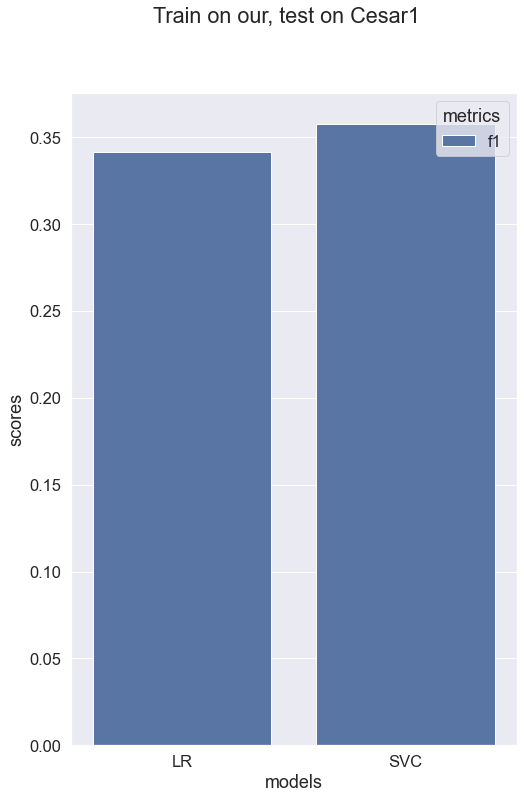

In [16]:
from source.postprocessing.plotter import dist_plot, bar_plot

dist_plot(results=estimators_score_distr, models=names, metrics=['f1'], plot_size=(8, 12), Title='GridSearch', filename='GS_LR_SVC.png')
# dist_plot(estimators_score_distr, ['RFC', 'GBM', 'LR', 'KNN'], 'kdeplot', 'f1', (15, 8), 'Title', 'test')
# bar_plot(results=estimators_scores_means, models=names, metrics=['f1'], plot_size=(8, 12), Title='Train on our, test on Cesar1', filename='Our_Cesar1.png')